### Disclaimer

#### This project is intended for educational purposes only. It does not constitute financial advice or a recommendation to buy or sell any financial instrument. Past performance is not indicative of future results. Always do your own research or consult with a licensed financial advisor before making investment decisions.

### Data Source Note:
#### Dataset: Historical data for OpenServ (SERV), Strawberry AI (BERRY), and VIBE AI (VIBE) was extracted from the [Crypto Technical](https://crypto-technical.streamlit.app) Streamlit app, covering each token's complete available trading history from launch to August 2024.
#### Purpose: Analysis focuses on RSI-based strategy performance for low-cap, on-chain tokens.

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [65]:
df = pd.read_csv('openserv.csv')
df.head()

,date,price,volume,market_cap,return,log_return,vol_change,SMA_10,SMA_50,EMA_12,...,macd_line,signal_line,macd_histogram,bb_upper,bb_middle,bb_lower,high,low,stoch_k,stoch_d
0,09/11/2024,0.015257,1204131.41,0.00,NaN,NaN,NaN,NaN,NaN,0.015257,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.015562,0.014952,NaN,NaN
1,10/11/2024,0.015257,1204131.41,0.00,0.000000,0.000000,0.000000,NaN,NaN,0.015257,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.015562,0.014952,NaN,NaN
2,11/11/2024,0.011147,1161645.77,7368708.93,-0.269385,-0.313868,-0.035283,NaN,NaN,0.013653,...,-0.000127,-0.000052,-0.000075,NaN,NaN,NaN,0.011370,0.010924,NaN,NaN
3,12/11/2024,0.015748,1176807.17,10409665.15,0.412757,0.345543,0.013052,NaN,NaN,0.014314,...,-0.000016,-0.000040,0.000024,NaN,NaN,NaN,0.016063,0.015433,NaN,NaN
4,13/11/2024,0.014178,947745.37,9408814.30,-0.099695,-0.105022,-0.194647,NaN,NaN,0.014277,...,-0.000018,-0.000033,0.000016,NaN,NaN,NaN,0.014462,0.013894,NaN,NaN


In [84]:
df = df[["date", "price", "volume", "market_cap"]]

In [83]:
def calculate_rsi(data, periods=14):
    delta = data['price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = calculate_rsi(df)

### Generating Buy/Sell Signals

In [68]:
df['Signal'] = 0
df.loc[df['RSI'] < 30, 'Signal'] = 1
df.loc[df['RSI'] > 70, 'Signal'] = -1

In [69]:
df['Returns'] = df['price'].pct_change()
df['Strategy_Returns'] = df['Returns'] * df['Signal'].shift(1)

In [82]:
df = df.dropna()

### Calculating Performance Metrics

In [76]:
df.loc[:, 'Cumulative_Strategy'] = (1 + df['Strategy_Returns']).cumprod()
df.loc[:, 'Cumulative_Market'] = (1 + df['Returns']).cumprod()

annualized_return = df['Strategy_Returns'].mean() * 365
annualized_volatility = df['Strategy_Returns'].std() * np.sqrt(365)
sharpe_ratio = annualized_return / annualized_volatility

df.loc[:, 'Cumulative_Max'] = df['Cumulative_Strategy'].cummax()
df.loc[:, 'Drawdown'] = (df['Cumulative_Strategy'] - df['Cumulative_Max']) / df['Cumulative_Max']
max_drawdown = df['Drawdown'].min()

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Total Strategy Return: {(df['Cumulative_Strategy'].iloc[-1] - 1):.2%}")
print(f"Total Market Return: {(df['Cumulative_Market'].iloc[-1] - 1):.2%}")

Sharpe Ratio: 0.12
Max Drawdown: -83.24%
Total Strategy Return: -42.97%
Total Market Return: 818.85%


### Visualization

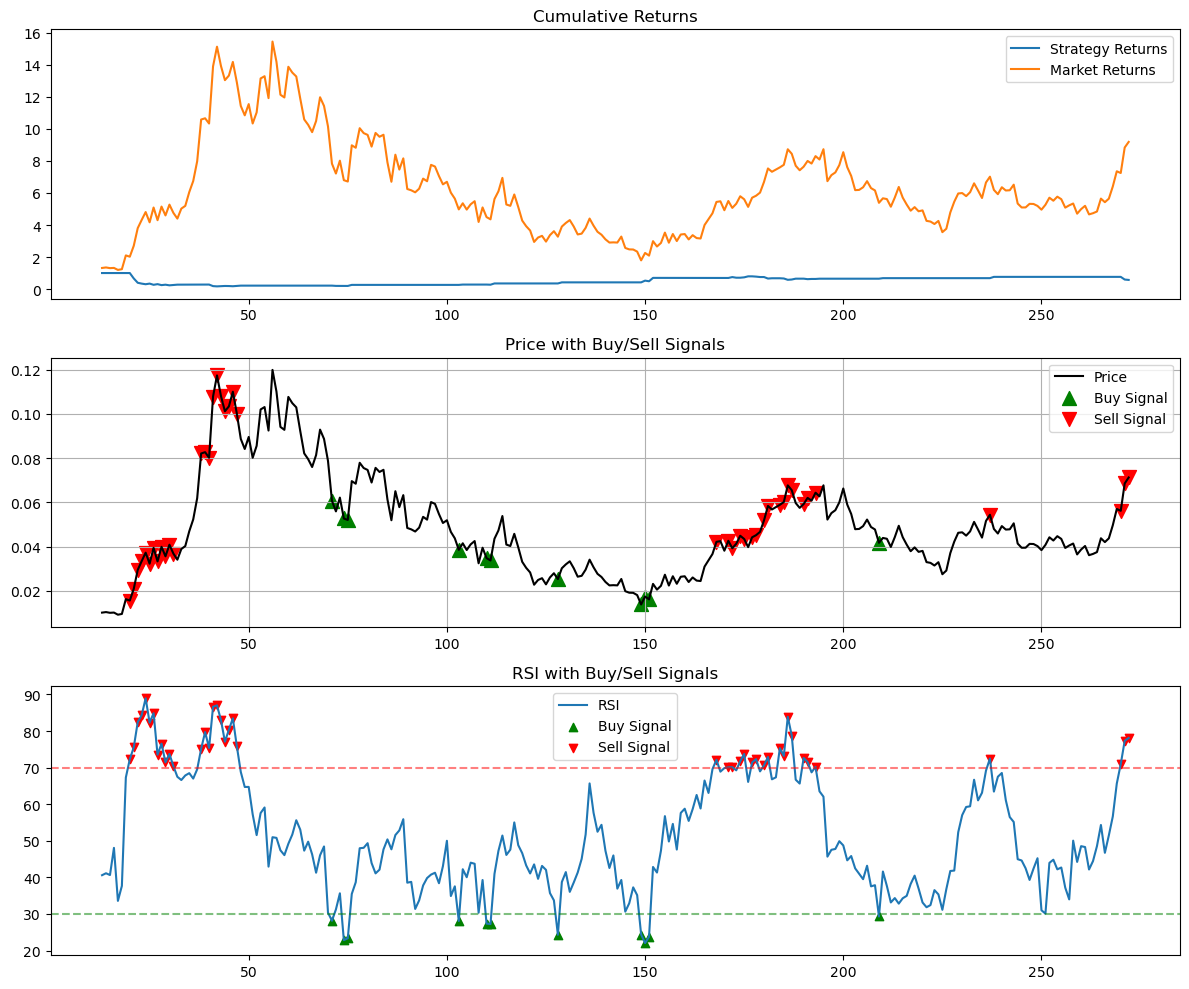

In [81]:
plt.figure(figsize=(12, 10))

# Plot cumulative returns
plt.subplot(3, 1, 1)
plt.plot(df.index, df['Cumulative_Strategy'], label='Strategy Returns')
plt.plot(df.index, df['Cumulative_Market'], label='Market Returns')
plt.title('Cumulative Returns')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df.index, df['price'], label='Price', color='black')
plt.scatter(df.index[df['Signal'] == 1], df['price'][df['Signal'] == 1], 
            color='green', label='Buy Signal', marker='^', s=100)
plt.scatter(df.index[df['Signal'] == -1], df['price'][df['Signal'] == -1], 
            color='red', label='Sell Signal', marker='v', s=100)
plt.title('Price with Buy/Sell Signals')
plt.legend()
plt.grid(True)

# Plot RSI with signals
plt.subplot(3, 1, 3)
plt.plot(df.index, df['RSI'], label='RSI')
plt.axhline(70, color='red', linestyle='--', alpha=0.5)
plt.axhline(30, color='green', linestyle='--', alpha=0.5)
plt.scatter(df.index[df['Signal'] == 1], df['RSI'][df['Signal'] == 1], color='green', label='Buy Signal', marker='^')
plt.scatter(df.index[df['Signal'] == -1], df['RSI'][df['Signal'] == -1], color='red', label='Sell Signal', marker='v')
plt.title('RSI with Buy/Sell Signals')
plt.legend()

plt.tight_layout()
plt.show()

### Final Verdict:
#### The RSI strategy is not profitable—in fact, it is loss-making for on-chain microcap tokens. This is evident from the high number of trades with incorrect signals, supported by our metrics: a Sharpe ratio of 0.12 and a maximum drawdown of -83.24%.